# Directed search

This is the third turial in a series showcasing the functionality of the Exploratory Modeling workbench. Exploratory modeling entails investigating the way in which uncertainty and/or policy levers map to outcomes. To investigate these mappings, we can either use sampling based strategies (open exploration) or optimization based strategies (directed search).

In this tutorial, I will demonstrate in more detail how to use the workbench for directed search. We are using the same example as in the previous tutorials. When using optimization, it is critical that you specify for each Scalar Outcome the direction in which it should move. There are three possibilities: info which is ignored, maximize, and minimize. If the `kind` keyword argument is not specified, it defaults to info.

In [1]:
from ema_workbench import RealParameter, ScalarOutcome, Constant, Model
from dps_lake_model import lake_model

model = Model("lakeproblem", function=lake_model)

# specify uncertainties
model.uncertainties = [
    RealParameter("b", 0.1, 0.45),
    RealParameter("q", 2.0, 4.5),
    RealParameter("mean", 0.01, 0.05),
    RealParameter("stdev", 0.001, 0.005),
    RealParameter("delta", 0.93, 0.99),
]

# set levers
model.levers = [
    RealParameter("c1", -2, 2),
    RealParameter("c2", -2, 2),
    RealParameter("r1", 0, 2),
    RealParameter("r2", 0, 2),
    RealParameter("w1", 0, 1),
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("max_P", ScalarOutcome.MINIMIZE),
    ScalarOutcome("utility", ScalarOutcome.MAXIMIZE),
    ScalarOutcome("inertia", ScalarOutcome.MAXIMIZE),
    ScalarOutcome("reliability", ScalarOutcome.MAXIMIZE),
]

# override some of the defaults of the model
model.constants = [
    Constant("alpha", 0.41),
    Constant("nsamples", 150),
    Constant("myears", 100),
]

Using directed search with the ema_workbench requires [platypus-opt](https://github.com/Project-Platypus/Platypus). Please check the installation suggestions provided in the readme of the github repository. I personally either install from github directly 


```
pip git+https://github.com/Project-Platypus/Platypus.git
```

or through pip

```
pip install platypus-opt
```

One note of caution: don't install platypus, but platypus-opt. There exists a python package on pip called platypus, but that is quite a different kind of libary. 

There are three ways in which we can use optimization in the workbench:
1. Search over the decision levers, conditional on a reference scenario
2. Search over the uncertain factors, conditional on a reference policy
3. Search over the decision levers given a set of scenarios

## Search over levers
Directed search is most often used to search over the decision levers in order to find good candidate strategies. This is for example the first step in the [Many Objective Robust Decision Making process](https://www.sciencedirect.com/science/article/pii/S1364815212003131). This is straightforward to do with the workbench using the optimize method. Note that I have kept the number of functional evaluations (nfe) very low. In real applications this should be substantially higher and be based on convergence considerations which are demonstrated below.


In [2]:
from ema_workbench import MultiprocessingEvaluator, ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.optimize(nfe=250, searchover="levers", epsilons=[0.1] * len(model.outcomes))

[MainProcess/INFO] pool started with 10 workers
299it [00:04, 72.90it/s]                                                       
[MainProcess/INFO] optimization completed, found 7 solutions
[MainProcess/INFO] terminating pool


the results from optimize is a DataFrame with the decision variables and outcomes of interest. 

In [3]:
results

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.118087,-0.422520,1.701297,1.679848,0.239590,2.283811,1.276214,0.988800,0.246667
1,-0.414358,0.899281,1.465926,1.461089,0.992863,2.283943,1.642493,0.989667,0.109133
2,-1.378786,0.838670,1.362124,0.137344,0.241236,2.283648,1.778130,0.990000,0.070000
3,1.903433,1.862835,0.397946,0.849478,0.374836,1.961342,0.637988,0.990000,0.070000
4,0.553898,1.153144,1.650626,1.785432,0.729250,2.283921,0.998691,0.969667,0.307733
5,0.708308,0.113918,0.844466,1.166550,0.101207,0.183769,0.501765,0.990000,1.000000
6,0.462691,-0.095183,1.620954,1.189571,0.682709,0.091275,0.219297,0.990000,1.000000


### Specifying constraints
It is possible to specify a constrained optimization problem. A model can have one or more constraints. A constraint can be applied to the model input parameters (both uncertainties and levers), and/or outcomes. A constraint is essentially a function that should return the distance from the feasibility threshold. The distance should be 0 if the constraint is met.


In [4]:
from ema_workbench import Constraint

constraints = [Constraint("max pollution", outcome_names="max_P", function=lambda x: max(0, x - 1))]

In [5]:
from ema_workbench import MultiprocessingEvaluator
from ema_workbench import ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.optimize(
        nfe=250, searchover="levers", epsilons=[0.1] * len(model.outcomes), constraints=constraints
    )

[MainProcess/INFO] pool started with 10 workers
296it [00:03, 74.88it/s]                                                       
[MainProcess/INFO] optimization completed, found 2 solutions
[MainProcess/INFO] terminating pool


In [6]:
results

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.162283,-1.365394,0.751341,1.560535,0.987879,0.094117,0.231352,0.99,1.0
1,0.878253,0.611719,1.900834,1.842844,0.350773,0.187601,0.506900,0.99,1.0


### Tracking convergence 
An important part of using many-objective evolutionary algorithms is to carefully monitor whether they have converged. Various different metrics can be used for this. The workbench supports two useful metrics known as hypervolume and epsilon progress. 

[MainProcess/INFO] pool started with 10 workers
10021it [01:15, 132.36it/s]                                                    
[MainProcess/INFO] optimization completed, found 18 solutions
[MainProcess/INFO] terminating pool


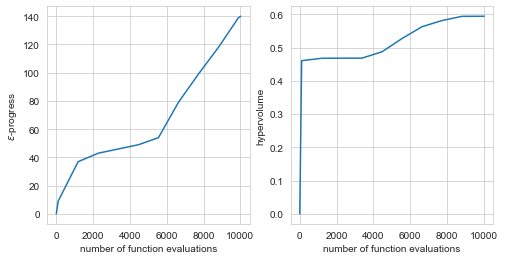

In [7]:
from ema_workbench.em_framework.optimization import HyperVolume, EpsilonProgress

convergence_metrics = [
    HyperVolume(minimum=[0, 0, 0, 0], maximum=[1, 1.01, 1.01, 1.01]),
    EpsilonProgress(),
]

with MultiprocessingEvaluator(model) as evaluator:
    results, convergence = evaluator.optimize(
        nfe=10000,
        searchover="levers",
        epsilons=[0.05] * len(model.outcomes),
        convergence=convergence_metrics,
        constraints=constraints,
    )

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8, 4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel("$\epsilon$-progress")
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel("hypervolume")

ax1.set_xlabel("number of function evaluations")
ax2.set_xlabel("number of function evaluations")
plt.show()

### Changing the reference scenario 

The workbench offers control over the reference scenario or policy under which you are performing the optimization. This makes it easy to aply multi-scenario MORDM ([Watson & Kasprzyk, 2017](https://www.sciencedirect.com/science/article/pii/S1364815216310593);[Eker & Kwakkel, 2018](https://doi.org/10.1016/j.envsoft.2018.03.029);[Bartholomew & Kwakkel, 2020](https://doi.org/10.1016/j.envsoft.2020.104699)). Alternatively, you can also use it to change the policy for which you are applying worst case scenario discovery (see below). 


```python
reference = Scenario('reference', b=0.4, q=2, mean=0.02, stdev=0.01)

with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.optimize(searchover='levers', nfe=1000,
                       epsilons=[0.1, ]*len(lake_model.outcomes),
                       reference=reference)
```


## Search over uncertainties: worst case discovery
Up till now, the focus has been on applying search to find promising candidate strategies. That is, we search through the lever space. However, there might also be good reasons to search through the uncertainty space. For example to search for worst case scenarios [(Halim et al, 2015)](https://www.sciencedirect.com/science/article/pii/S0016328715001342). This is easily achieved as shown below. We change the kind attribute on each outcome so that we search for the worst outcome and specify that we would like to search over the uncertainties instead of the levers.

Any of the foregoing additions such as constraints or converence work as shown above. Note that if you would like to to change the reference policy, reference should be a Policy object rather than a Scenario object.


In [8]:
# change outcomes so direction is undesirable
minimize = ScalarOutcome.MINIMIZE
maximize = ScalarOutcome.MAXIMIZE

for outcome in model.outcomes:
    if outcome.kind == minimize:
        outcome.kind = maximize
    else:
        outcome.kind = minimize

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.optimize(
        nfe=1000, searchover="uncertainties", epsilons=[0.1] * len(model.outcomes)
    )

[MainProcess/INFO] pool started with 10 workers
1092it [00:10, 108.71it/s]                                                     
[MainProcess/INFO] optimization completed, found 5 solutions
[MainProcess/INFO] terminating pool


## Parallel coordinate plots

The workbench comes with support for making parallel axis plots through the parcoords module. This module offers a parallel axes object on which we can plot data. The typical workflow is to first instantiate this parallel axes object given a pandas dataframe with the upper and lower limits for each axes. Next, one or more datasets can be plotted on this axes. Any dataframe passed to the plot method will be normalized using the limits passed first. We can also invert any of the axes to ensure that the desirable direction is the same for all axes.

/Users/jhkwakkel/Documents/GitHub/EMAworkbench/ema_workbench/analysis/prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive " "inspection not available"), ImportWarning)


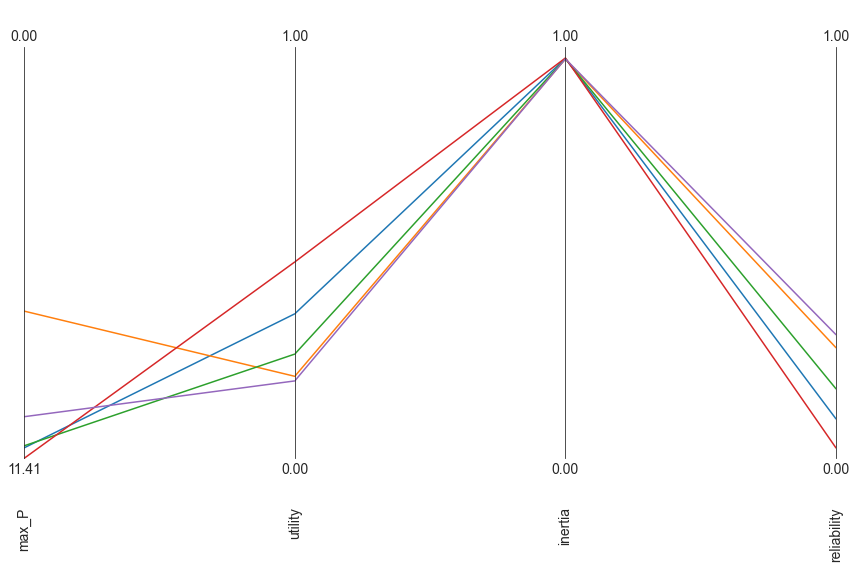

In [9]:
from ema_workbench.analysis import parcoords

data = results.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, ["utility", "inertia", "reliability", "max_P"]] = 0
limits.loc[1, ["utility", "inertia", "reliability"]] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("max_P")
plt.show()

## Robust Search

In the foregoing, we have been using optimization over levers or uncertainties, while assuming a reference scenario or policy. However, we can also formulate a robust many objective optimization problem ([Kwakkel et al. 2015](https://doi.org/10.1007/s10584-014-1210-4); [Bartholomew et al. 2020](https://doi.org/10.1016/j.envsoft.2020.104699)), were we are going to search over the levers for solutions that have robust performance over a set of scenarios. To do this with the workbench, there are several steps that one has to take.

First, we need to specify our robustness metrics. A robustness metric takes as input the performance of a candidate policy over a set of scenarios and returns a single robustness score. For a more in depth overview, see [McPhail et al. (2018)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017EF000649). In case of the workbench, we can use the ScalarOutcome class for this. We need to specify the name of the robustness metric a function that takes as input a numpy array and returns a single number, and the model outcome to which this function should be applied. 

Below, we use a percentile based robustness metric, which we apply to each model outcome. 

In [10]:
import functools

percentile10 = functools.partial(np.percentile, q=10)
percentile90 = functools.partial(np.percentile, q=90)

MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE
robustnes_functions = [
    ScalarOutcome(
        "90th percentile max_p", kind=MINIMIZE, variable_name="max_P", function=percentile90
    ),
    ScalarOutcome(
        "10th percentile reliability",
        kind=MAXIMIZE,
        variable_name="reliability",
        function=percentile10,
    ),
    ScalarOutcome(
        "10th percentile inertia", kind=MAXIMIZE, variable_name="inertia", function=percentile10
    ),
    ScalarOutcome(
        "10th percentile utility", kind=MAXIMIZE, variable_name="utility", function=percentile10
    ),
]

Next, we have to generate the scenarios we want to use. Below we generate 50 scenarios, which we will keep fixed over the optimization. The exact number of scenarios to use is to be established through trial and error. Typically it involves balancing computational costs of more scenarios, with the stability of the robustness metric over the number of scenarios

In [11]:
from ema_workbench.em_framework import sample_uncertainties

n_scenarios = 10
scenarios = sample_uncertainties(model, n_scenarios)

With the robustness metrics specified, and the scenarios, sampled, we can now perform robust many-objective optimization. Below is the code that one would run. Note that this is computationally very expensive since each candidate solution is going to be run for ten scenarios before we can calculate the robustness for each outcome of interest.

To track convergence, we track epsilon progress. We also store the archive to disk for every 1000 function evaluations (this is the default value of the workbench). 

In [12]:
from ema_workbench.em_framework import ArchiveLogger

convergence_metrics = [
    ArchiveLogger(
        "./archives", [l.name for l in model.levers], [o.name for o in robustnes_functions]
    ),
    EpsilonProgress(),
]

nfe = int(5e4)
with MultiprocessingEvaluator(model) as evaluator:
    robust_results, convergence = evaluator.robust_optimize(
        robustnes_functions,
        scenarios,
        nfe=nfe,
        epsilons=[
            0.025,
        ]
        * len(robustnes_functions),
        convergence=convergence_metrics,
    )

[MainProcess/INFO] pool started with 10 workers
50035it [54:34, 15.28it/s]                                                     
[MainProcess/INFO] optimization completed, found 11 solutions
[MainProcess/INFO] terminating pool


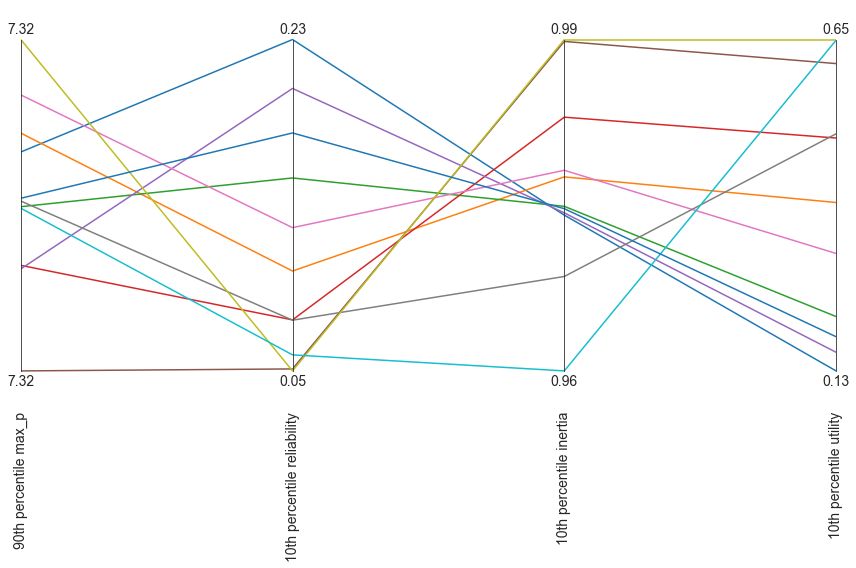

In [13]:
data = robust_results.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(robust_results)
paraxes.invert_axis("90th percentile max_p")
plt.show()

some text needs to go here

In [14]:
import os
from ema_workbench.em_framework.optimization import to_robust_problem
from platypus import Solution, Hypervolume, GenerationalDistance, EpsilonIndicator


problem = to_robust_problem(model, scenarios, robustnes_functions)


def rebuild_platypus_population(archive):
    solutions = []
    for i, row in archive.iterrows():
        decision_variables = row[problem.parameter_names]
        objectives = row[problem.outcome_names]

        solution = Solution(problem)
        solution.variables = decision_variables.values.tolist()
        solution.objectives = objectives.values.tolist()
        solutions.append(solution)
    return solutions


# rebuild the platypus population for the final archive
# and use this as our reference set for calculating hypervolume against
reference_set = rebuild_platypus_population(robust_results)
hv = Hypervolume(reference_set=reference_set)
gd = GenerationalDistance(reference_set, d=4)
ei = EpsilonIndicator(reference_set)

metrics = []

root = "./archives"
for entry in os.listdir(root):
    if not entry.startswith("archive"):
        continue
    _, index, nfe, _ = entry.split("_")

    if index == "1":
        continue  # first run contains no archive yet

    link = os.path.join(root, entry)
    archive = pd.read_csv(link)
    archive = rebuild_platypus_population(archive)

    scores = {
        "generational_distance": gd.calculate(archive),
        "hypervolume": hv.calculate(archive),
        "epsilon_indicator": ei.calculate(archive),
        "nfe": int(nfe),
    }

    metrics.append(scores)

In [15]:
metrics = pd.DataFrame.from_dict(metrics)
metrics.sort_values(by="nfe", inplace=True)

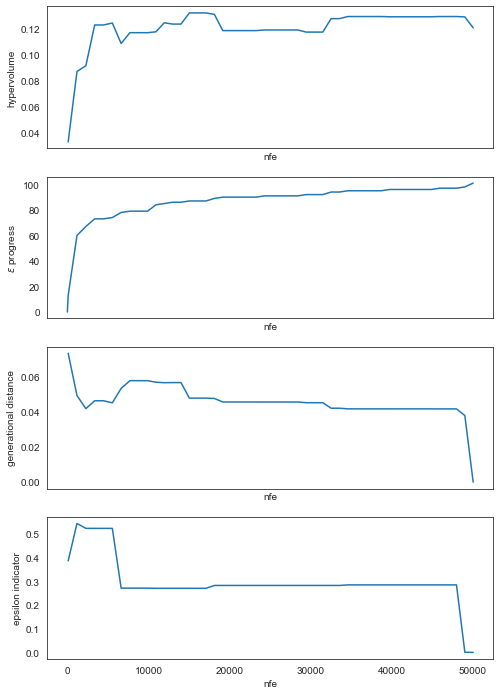

In [16]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(8, 12), sharex=True)

ax1.plot(metrics.nfe, metrics.hypervolume)
ax1.set_xlabel("nfe")
ax1.set_ylabel("hypervolume")

ax2.plot(convergence.nfe, convergence.epsilon_progress)
ax2.set_xlabel("nfe")
ax2.set_ylabel("$\epsilon$ progress")

ax3.plot(metrics.nfe, metrics.generational_distance)
ax3.set_xlabel("nfe")
ax3.set_ylabel("generational distance")

ax4.plot(metrics.nfe, metrics.epsilon_indicator)
ax4.set_xlabel("nfe")
ax4.set_ylabel("epsilon indicator")

plt.show()